# rf712_lagrangianmorphfit
Performing a simple fit with RooLagrangianMorphFunc.
a morphing function is setup as a function of three variables and
a fit is performed on a pseudo-dataset.




**Author:** Rahul Balasubramanian  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Monday, May 13, 2024 at 11:37 AM.</small></i>

In [1]:
%%cpp -d
#include <RooDataHist.h>
#include <RooFitResult.h>
#include <RooLagrangianMorphFunc.h>
#include <RooPlot.h>
#include <RooRealVar.h>

#include <TAxis.h>
#include <TCanvas.h>
#include <TH2.h>
#include <TStyle.h>

using namespace RooFit;

Create variables for
morphing function
---------------------------------------------

In [2]:
std::string observablename = "pTV";
RooRealVar obsvar(observablename.c_str(), "observable of pTV", 10, 600);
RooRealVar kSM("kSM", "sm modifier", 1.0);
RooRealVar cHq3("cHq3", "EFT modifier", -10.0, 10.0);
cHq3.setAttribute("NewPhysics", true);
RooRealVar cHl3("cHl3", "EFT modifier", -10.0, 10.0);
cHl3.setAttribute("NewPhysics", true);
RooRealVar cHDD("cHDD", "EFT modifier", -10.0, 10.0);
cHDD.setAttribute("NewPhysics", true);

Inputs needed for config
---------------------------------------------

In [3]:
std::string infilename = std::string(gROOT->GetTutorialDir()) + "/roofit/input_histos_rf_lagrangianmorph.root";
std::vector<std::string> samplelist = {"SM_NPsq0",        "cHq3_NPsq1",     "cHq3_NPsq2", "cHl3_NPsq1",
                                       "cHl3_NPsq2",      "cHDD_NPsq1",     "cHDD_NPsq2", "cHl3_cHDD_NPsq2",
                                       "cHq3_cHDD_NPsq2", "cHl3_cHq3_NPsq2"};

Setup Config
---------------------------------------------

In [4]:
RooLagrangianMorphFunc::Config config;
config.fileName = infilename;
config.observableName = observablename;
config.folderNames = samplelist;
config.couplings.add(cHq3);
config.couplings.add(cHl3);
config.couplings.add(cHDD);
config.couplings.add(kSM);

Create morphing function
---------------------------------------------

In [5]:
RooLagrangianMorphFunc morphfunc("morphfunc", "morphed dist. of pTV", config);

[#0] PROGRESS:InputArguments -- initializing physics inputs from file /home/sftnight/build/workspace/root-makedoc-master/rootspi/rdoc/src/master.build/tutorials/roofit/input_histos_rf_lagrangianmorph.root with object name(s) 'pTV'


Create pseudo data histogram
for fit
---------------------------------------------

In [6]:
morphfunc.setParameter("cHq3", 0.01);
morphfunc.setParameter("cHl3", 1.0);
morphfunc.setParameter("cHDD", 0.2);

auto pseudo_hist = morphfunc.createTH1("pseudo_hist");
auto pseudo_dh = new RooDataHist("pseudo_dh", "pseudo_dh", RooArgList(obsvar), pseudo_hist);

[#0] PROGRESS:Caching -- creating cache from getCache function for 0x7ff6c8052000
[#0] PROGRESS:Caching -- current storage has size 10
[#0] PROGRESS:ObjectHandling -- observable: pTV
[#0] PROGRESS:ObjectHandling -- binWidth: binWidth_pTV
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(pseudo_dh): fit range of variable pTV expanded to nearest bin boundaries: [10,600] --> [0,600]


reset parameters to zeros before fit

In [7]:
morphfunc.setParameter("cHq3", 0.0);
morphfunc.setParameter("cHl3", 0.0);
morphfunc.setParameter("cHDD", 0.0);

error set used as initial step size

In [8]:
cHq3.setError(0.1);
cHl3.setError(0.1);
cHDD.setError(0.1);

Wrap pdf on morphfunc and
fit to data histogram
---------------------------------------------
wrapper pdf to normalise morphing function to a morphing pdf

In [9]:
RooWrapperPdf model("wrap_pdf", "wrap_pdf", morphfunc);
auto fitres = model.fitTo(*pseudo_dh, SumW2Error(true), Optimize(false), Save(), PrintLevel(-1));
auto hcorr = fitres->correlationHist();

[#0] PROGRESS:Caching -- creating cache from getCache function for 0x7ff6b5fcf050
[#0] PROGRESS:Caching -- current storage has size 10
[#0] PROGRESS:ObjectHandling -- observable: pTV
[#0] PROGRESS:ObjectHandling -- binWidth: binWidth_pTV

[#1] INFO:Fitting -- RooAbsPdf::fitTo(wrap_pdf_over_wrap_pdf_Int[pTV]) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- using CPU computation library compiled with -mavx2
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_wrap_pdf_over_wrap_pdf_Int[pTV]_pseudo_dh) Summation contains a RooNLLVar, using its error level
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (86348.3) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	cHDD=0	cHl3=0	cHq3=-0.0202918
RooAbsPdf::wrap_pdf_over_wrap_pdf_Int[pTV][ numerator=wrap_pdf denominator=wrap_pdf_Int[pTV] ]
     p.d.f value is less than zero, trying to recover @ numerator=wrap_pdf=0.0376648

Extract postfit distribution
and plot with initial
histogram
---------------------------------------------

In [10]:
auto postfit_hist = morphfunc.createTH1("morphing_postfit_hist");
RooDataHist postfit_dh("morphing_postfit_dh", "morphing_postfit_dh", RooArgList(obsvar), postfit_hist);

auto frame0 = obsvar.frame(Title("Fitted histogram of p_{T}^{V}"));
postfit_dh.plotOn(frame0, Name("postfit_dist"), DrawOption("C"), LineColor(kBlue), DataError(RooAbsData::None),
                  XErrorSize(0));
pseudo_dh->plotOn(frame0, Name("input"));

[#1] INFO:InputArguments -- RooAbsData::plotOn(pseudo_dh) INFO: dataset has non-integer weights, auto-selecting SumW2 errors instead of Poisson errors
[#1] INFO:Plotting -- RooPlot::updateFitRangeNorm: New event count of 7389.24 will supersede previous event count of 9313.81 for normalization of PDF projections


Draw plots on canvas
---------------------------------------------

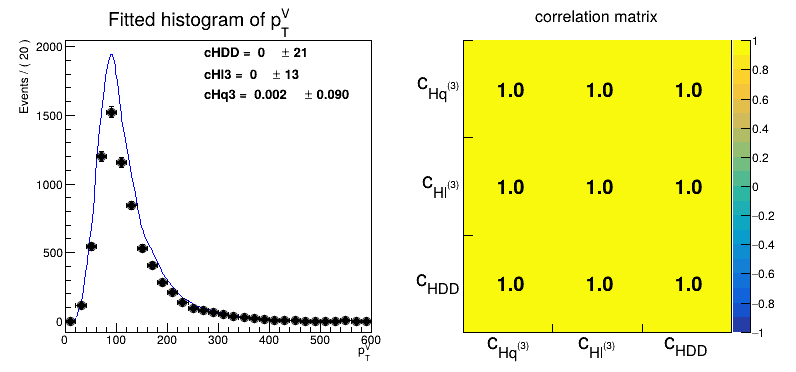

Info in <TCanvas::Print>: png file rf712_lagrangianmorphfit.png has been created


In [11]:
TCanvas *c1 = new TCanvas("fig3", "fig3", 800, 400);
c1->Divide(2, 1);

c1->cd(1);
gPad->SetLeftMargin(0.15);
gPad->SetRightMargin(0.05);

model.paramOn(frame0, Layout(0.50, 0.75, 0.9), Parameters(config.couplings));
frame0->GetXaxis()->SetTitle("p_{T}^{V}");
frame0->Draw();

c1->cd(2);
gPad->SetLeftMargin(0.15);
gPad->SetRightMargin(0.15);
gStyle->SetPaintTextFormat("4.1f");
gStyle->SetOptStat(0);
hcorr->SetMarkerSize(3.);
hcorr->SetTitle("correlation matrix");
hcorr->GetYaxis()->SetTitleOffset(1.4);
hcorr->GetYaxis()->SetLabelSize(0.1);
hcorr->GetXaxis()->SetLabelSize(0.1);
hcorr->GetYaxis()->SetBinLabel(1, "c_{HDD}");
hcorr->GetYaxis()->SetBinLabel(2, "c_{Hl^{(3)}}");
hcorr->GetYaxis()->SetBinLabel(3, "c_{Hq^{(3)}}");
hcorr->GetXaxis()->SetBinLabel(3, "c_{HDD}");
hcorr->GetXaxis()->SetBinLabel(2, "c_{Hl^{(3)}}");
hcorr->GetXaxis()->SetBinLabel(1, "c_{Hq^{(3)}}");
hcorr->Draw("colz text");
c1->SaveAs("rf712_lagrangianmorphfit.png");

Draw all canvases 

In [12]:
%jsroot on
gROOT->GetListOfCanvases()->Draw()